## Shap Deep Explainer

> compare with this data [SHAP Deep Explainer (Pytorch Ver)](https://www.kaggle.com/subinium/shap-deep-explainer-pytorch-ver)

CNN Code from [[Pytorch] 1. ANN & Simple CNN](https://www.kaggle.com/subinium/pytorch-1-ann-simple-cnn) kernel.

## Simple CNN with Pytorch

In [1]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import numpy as np
import shap

In [2]:
train = pd.read_csv("../input/digit-recognizer/train.csv",dtype = np.float32)


target = train.label.values
train = train.loc[:,train.columns != "label"].values/255 

X_train, X_test, y_train, y_test = train_test_split(train, target, test_size = 0.2, random_state = 42) 

X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train).type(torch.LongTensor) # data type is long

X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test).type(torch.LongTensor) # data type is long

batch_size = 128
num_epochs = 100

train = torch.utils.data.TensorDataset(X_train, y_train)
test = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)


### CNN Model Class & Train

In [3]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 
    
    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out
    
# Create CNN
model = CNNModel()

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# CNN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        train = Variable(images.view(-1, 1, 28, 28))
        labels = Variable(labels)
        
        
        optimizer.zero_grad() # Clear gradients
        outputs = model(train) # Forward propagation
        loss = error(outputs, labels) # Calculate softmax and cross entropy loss
        loss.backward() # Calculating gradients
        optimizer.step() # Update parameters
        
        count += 1
        
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            
            # Predict test dataset
            for images, labels in test_loader:
                test = Variable(images.view(-1, 1, 28, 28))
                outputs = model(test) # Forward propagation
                predicted = torch.max(outputs.data, 1)[1] # Get predictions from the maximum value
                total += len(labels) # Total number of labels
                correct += (predicted == labels).sum() # Total correct predictions
            
            accuracy = 100.0 * correct.item() / total
            
            # store loss and iteration
            loss_list.append(loss.data.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 500 == 0:
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data.item(), accuracy))

Iteration: 500  Loss: 0.04599495604634285  Accuracy: 96.97619047619048 %
Iteration: 1000  Loss: 0.10544389486312866  Accuracy: 97.16666666666667 %
Iteration: 1500  Loss: 0.017760474234819412  Accuracy: 98.01190476190476 %
Iteration: 2000  Loss: 0.038806695491075516  Accuracy: 97.8452380952381 %
Iteration: 2500  Loss: 0.051236335188150406  Accuracy: 98.28571428571429 %
Iteration: 3000  Loss: 0.019511453807353973  Accuracy: 98.21428571428571 %
Iteration: 3500  Loss: 0.035924751311540604  Accuracy: 98.44047619047619 %
Iteration: 4000  Loss: 0.022338159382343292  Accuracy: 98.46428571428571 %
Iteration: 4500  Loss: 0.006624482572078705  Accuracy: 98.23809523809524 %
Iteration: 5000  Loss: 0.007145252078771591  Accuracy: 98.26190476190476 %
Iteration: 5500  Loss: 0.021417856216430664  Accuracy: 98.26190476190476 %
Iteration: 6000  Loss: 0.005996540188789368  Accuracy: 98.20238095238095 %
Iteration: 6500  Loss: 0.0066935159265995026  Accuracy: 98.36904761904762 %
Iteration: 7000  Loss: 0.006

## Shap Value : Deep Explainer

[official documentation](https://shap.readthedocs.io/en/latest/#shap.DeepExplainer)

Meant to approximate SHAP values for deep learning models.

This is an enhanced version of the DeepLIFT algorithm (Deep SHAP) where, similar to Kernel SHAP, we approximate the conditional expectations of SHAP values using a selection of background samples. Lundberg and Lee, NIPS 2017 showed that the per node attribution rules in DeepLIFT (Shrikumar, Greenside, and Kundaje, arXiv 2017) can be chosen to approximate Shapley values. By integrating over many backgound samples DeepExplainer estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

**`shap_values(X, ranked_outputs=None, output_rank_order='max')`**

Return approximate SHAP values for the model applied to the data given by X.

**`X :list,`**

if framework == ‘tensorflow’: numpy.array, or pandas.DataFrame if framework == ‘pytorch’: torch.tensor A tensor (or list of tensors) of samples (where X.shape[0] == # samples) on which to explain the model’s output.


**`ranked_outputs :None or int`**

If ranked_outputs is None then we explain all the outputs in a multi-output model. If ranked_outputs is a positive integer then we only explain that many of the top model outputs (where “top” is determined by output_rank_order). Note that this causes a pair of values to be returned (shap_values, indexes), where shap_values is a list of numpy arrays for each of the output ranks, and indexes is a matrix that indicates for each sample which output indexes were choses as “top”.

**`output_rank_order :“max”, “min”, or “max_abs”`**

How to order the model outputs when using ranked_outputs, either by maximum, minimum, or maximum absolute value.
For a models with a single output this returns a tensor of SHAP values with the same shape as X. For a model with multiple outputs this returns a list of SHAP value tensors, each of which are the same shape as X. If ranked_outputs is None then this list of tensors matches the number of model outputs. If ranked_outputs is a positive integer a pair is returned (shap_values, indexes), where shap_values is a list of tensors with a length of ranked_outputs, and indexes is a matrix that indicates for each sample which output indexes were chosen as “top”.

In [4]:
batch = next(iter(test_loader))
images, _ = batch
images = images.view(-1, 1, 28, 28)

background = images[:100]
test_images= images[100:110]

e = shap.DeepExplainer(model, images)
shap_values = e.shap_values(test_images)

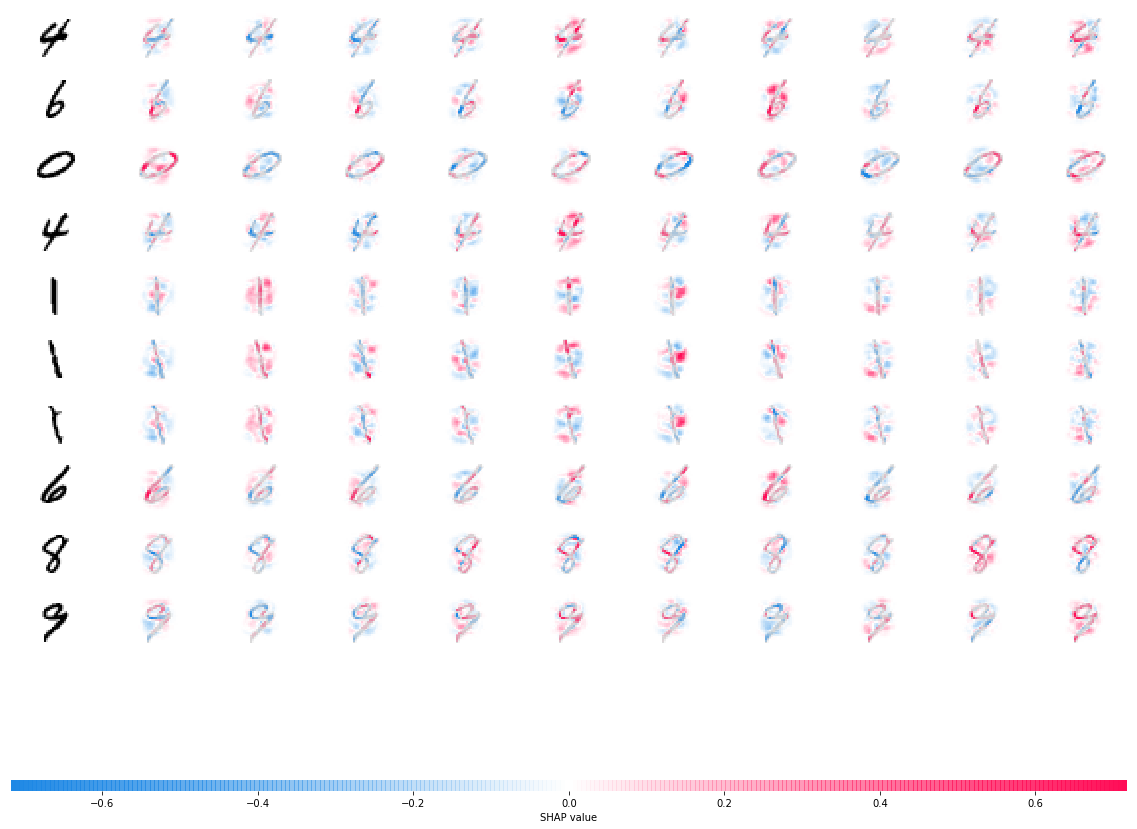

In [5]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, -test_numpy)

In [6]:
print(_[100:110])

tensor([4, 6, 0, 4, 1, 1, 1, 6, 8, 9])


The plot above shows the explanations for each class on four predictions. Note that the explanations are ordered for the classes 0-9 going left to right along the rows.